In [1]:
import pandas as pd # 추가설치
import pandas_datareader as pdr  # 추가설치
import talib # 추가설치
import matplotlib.pyplot as plt # 추가설치
import numpy as np # 추가설치
import scipy.stats as stats # 추가설치
import math
from sklearn.preprocessing import MinMaxScaler

C:\Users\HIT-2233\Anaconda3\envs\py36\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## DataLoad

In [2]:
# data Load
df = pd.read_csv('../../data/ch08/intc.csv',
                 index_col='Date',
                 parse_dates=True)
sox_df = pd.read_csv('../../data/ch08/sox_df.csv',
                     index_col='Date',
                     parse_dates=True)
vix_df = pd.read_csv('../../data/ch08/vix_df.csv',
                     index_col='Date',
                     parse_dates=True)
snp500_df = pd.read_csv('../../data/ch08/s&p500.csv',
                        index_col='Date',
                        parse_dates=True)

## Data Features

In [3]:
df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
# Moving Average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

# Momentum Indicators
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators 

#4.ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [4]:
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left')
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

In [12]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_price,next_rtn,log_return,CCI,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,26.504349,28.013699,-0.017897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1469.250000,704.559998,24.639999
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,28.013699,26.705585,0.044849,0.055385,NaN,...,NaN,NaN,NaN,2.34375,NaN,NaN,NaN,1455.219971,713.200012,24.209999
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,26.705585,26.926966,-0.029261,-0.047821,NaN,...,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,1399.420044,687.320007,27.010000
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,26.926966,25.357227,0.007530,0.008255,NaN,...,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN,1402.109985,678.539978,26.410000
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,25.357227,26.403713,-0.036697,-0.060064,NaN,...,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,1403.449951,669.330017,25.730000


In [5]:
# feature list
# feature_list = ['Adj Close', 'log_return', 'CCI','next_price']
# 볼린저 밴드와 MACD를 어떻게 활용해야할까? 음. 아님 그냥 그대로 사용하는 건가?
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [6]:
phase_flag = '3'

if phase_flag == '1' :
    train_from = '2010-01-04'
    train_to = '2012-01-01'

    val_from = '2012-01-01'
    val_to = '2012-04-01'

    test_from = '2012-04-01'
    test_to = '2012-07-01'

elif phase_flag == '2' :
    train_from = '2012-07-01'
    train_to = '2014-07-01'

    val_from = '2014-07-01'
    val_to = '2014-10-01'

    test_from = '2014-10-01'
    test_to = '2015-01-01'
    
else : 
    train_from = '2015-01-01'
    train_to = '2017-01-01'

    val_from = '2017-01-01'
    val_to = '2017-04-01'

    test_from = '2017-04-01'
    test_to = '2017-07-01'

In [7]:
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [8]:
train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,31.625349,23605600.0,0.001927,0.360369,0.422398,37.964195,35.625804,...,36.828,36.961,0.070000,-0.820000,8.634596,-57.261459,2058.199951,686.729980,17.790001,-0.008454
2015-01-05,36.200001,36.450001,35.939999,31.268734,32785000.0,-0.011340,0.359143,0.416504,37.902114,35.536885,...,36.508,36.854,-0.410000,-0.809998,4.902248,-74.273902,2020.579956,673.590027,19.920000,-0.006906
2015-01-06,36.080002,36.230000,35.259998,30.685978,30847600.0,-0.018813,0.429746,0.417354,37.855069,35.344930,...,36.128,36.745,-0.670002,-1.010002,4.937537,-99.193531,2002.609985,658.830017,21.120001,-0.022173
2015-01-07,35.639999,36.070000,35.270000,31.329620,27725200.0,0.020758,0.449678,0.396641,37.788620,35.293380,...,35.980,36.626,0.740002,-0.340000,12.879977,-69.354794,2025.900024,665.270020,19.309999,0.010662
2015-01-08,36.369999,37.000000,36.259998,31.912374,31765400.0,0.018430,0.450896,0.396890,37.770449,35.291550,...,36.060,36.552,0.669998,0.739998,16.587224,-42.338775,2062.139893,684.650024,17.010000,0.008798


In [9]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

In [10]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [11]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,31.625349,23605600.0,0.001927,0.360369,0.422398,37.964195,35.625804,...,0.611705,0.900729,0.926549,0.622449,0.408772,0.624169,0.427385,0.517622,0.335631,0.221242
2015-01-05,36.200001,36.450001,35.939999,31.268734,32785000.0,-0.011340,0.359143,0.416504,37.902114,35.536885,...,0.576726,0.872265,0.916140,0.524490,0.410527,0.552398,0.257261,0.432631,0.301055,0.293519
2015-01-06,36.080002,36.230000,35.259998,30.685978,30847600.0,-0.018813,0.429746,0.417354,37.855069,35.344930,...,0.526877,0.838463,0.905536,0.471428,0.375438,0.553077,0.008065,0.392034,0.262216,0.334238
2015-01-07,35.639999,36.070000,35.270000,31.329620,27725200.0,0.020758,0.449678,0.396641,37.788620,35.293380,...,0.511096,0.825298,0.893959,0.759184,0.492983,0.705804,0.306452,0.444650,0.279162,0.272820
2015-01-08,36.369999,37.000000,36.259998,31.912374,31765400.0,0.018430,0.450896,0.396890,37.770449,35.291550,...,0.519944,0.832414,0.886759,0.744898,0.682456,0.777092,0.576612,0.526523,0.330158,0.194774


### LSTM Model 훈련데이터 구분하기

In [12]:
num_step = 5
num_unit = 200

In [13]:
def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))
    
    train_ydata = np.array(data[[feature_list[n]]])
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1))
    return x_batch, y_batch

In [14]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1
# LSTM할때 사용했던 소스코드.
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [16]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    229.0
1    270.0
dtype: float32
0    29.0
1    28.0
dtype: float32
0    31.0
1    27.0
dtype: float32


### 모델을 수정해보자 Keras로 

In [17]:
x_train.shape[1]
# 이것은 전체 데이터를 242 rolling , 10 window, 2개 feature를 본다는 것이다.
# 2개 feature를 10개 묶음으로 보는데, 1칸씩 미루면서 보니 242개 데이터를 본다는 것이다.

5

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [19]:
# 랜덤시드 고정시키기
np.random.seed(23)

# LSTM 모델을 생성한다.
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 200)            178400    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 200)            800       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
dropout (Dropout)            (None, 5, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 200)            800   

https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
이 말인 즉슨 LSTM이 자체 gate 별 활성화 함수를 갖고있다.

In [21]:
y_val.shape

(57, 2)

In [22]:
history = model.fit(x_train,y_train,epochs=20, batch_size=10, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 499 samples, validate on 57 samples
Epoch 1/20
499/499 [==============================] - 13s 26ms/sample - loss: 5.7309 - acc: 0.5311 - val_loss: 2.5846 - val_acc: 0.4912
Epoch 2/20
499/499 [==============================] - 7s 14ms/sample - loss: 1.7384 - acc: 0.5411 - val_loss: 1.1624 - val_acc: 0.4912
Epoch 3/20
499/499 [==============================] - 6s 12ms/sample - loss: 0.9999 - acc: 0.5351 - val_loss: 0.8470 - val_acc: 0.4912
Epoch 4/20
499/499 [==============================] - 6s 12ms/sample - loss: 0.7996 - acc: 0.5170 - val_loss: 0.7497 - val_acc: 0.5789
Epoch 5/20
499/499 [==============================] - 6s 11ms/sample - loss: 0.7378 - acc: 0.5291 - val_loss: 0.7345 - val_acc: 0.4912
Epoch 6/20
499/499 [==============================] - 6s 13ms/sample - loss: 0.7344 - acc: 0.5431 - val_loss: 0.7055 - val_acc: 0.5263
Epoch 7/20
499/499 [==============================

In [23]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

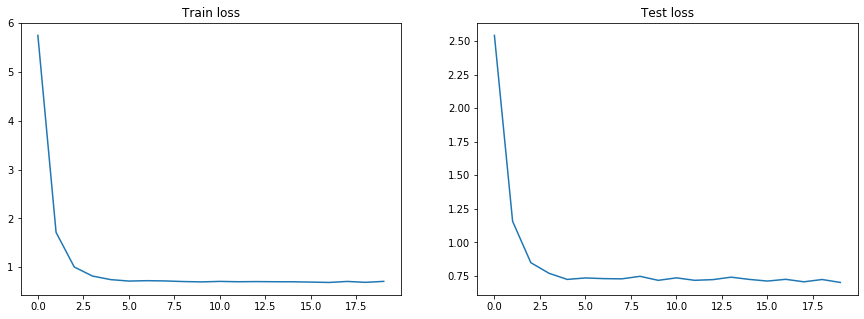

In [34]:
plot_history(history) # 1단계

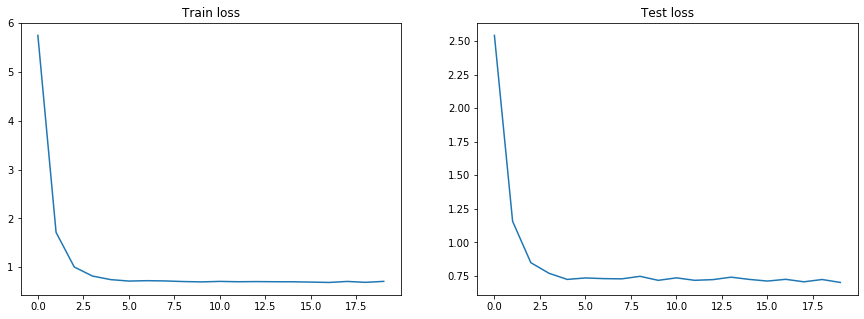

In [36]:
plot_history(history) # 2단계

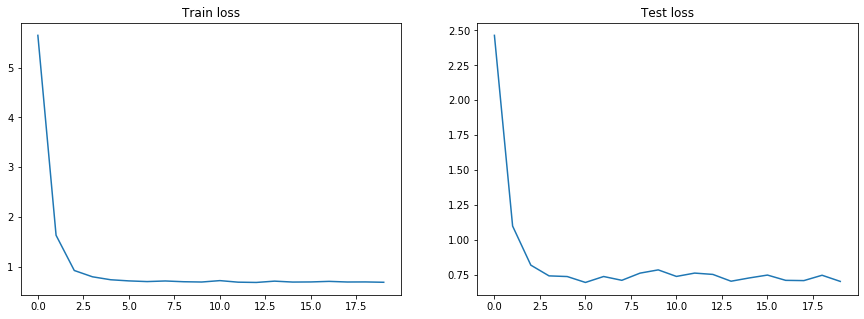

In [24]:
plot_history(history) # 3단계

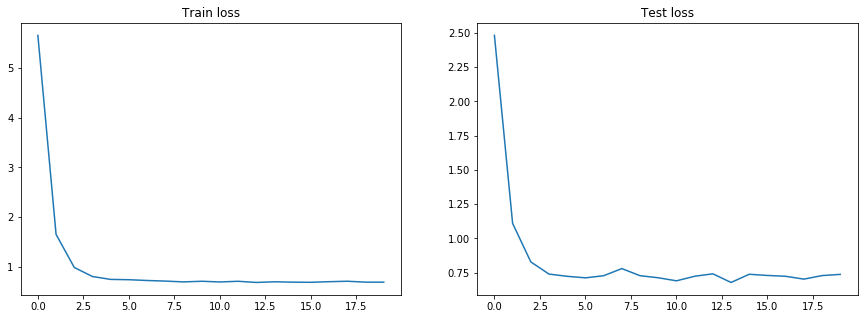

In [96]:
plot_history(history) # 3단계

In [90]:
# model.save('model_functional_open_close_binary_phase3.h5')

## 에측

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
predicted = model.predict(x_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

## ROC AUC 커브 만들어보기.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

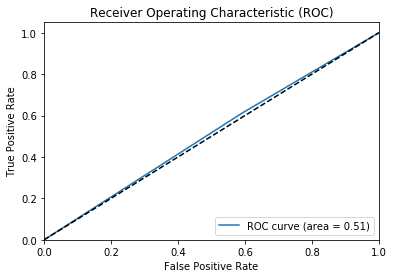

In [146]:
# 1단계
plot_roc(y_pred,Y_test)

In [147]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.5102


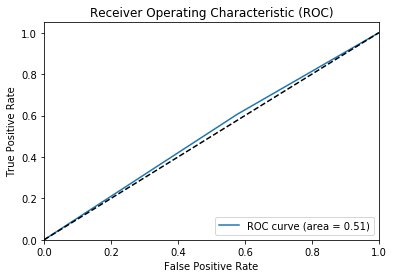

In [27]:
# 2단계
plot_roc(y_pred,Y_test)

In [37]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.5146


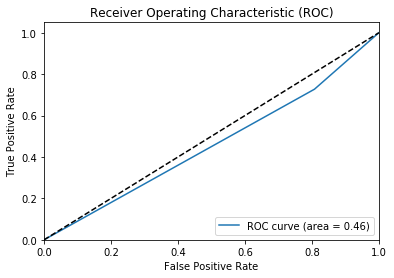

In [209]:
# 2단계
plot_roc(y_pred,Y_test)

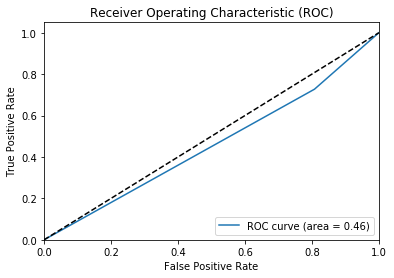

In [205]:
# 2단계
plot_roc(y_pred,Y_test)

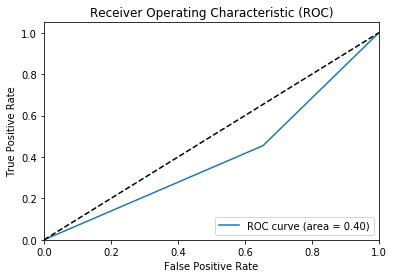

In [181]:
# 2단계
plot_roc(y_pred,Y_test)

In [210]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.4598


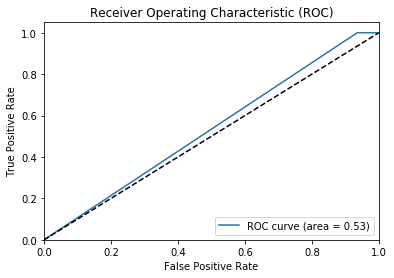

In [27]:
# 3단계
plot_roc(y_pred,Y_test)

In [28]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.5323


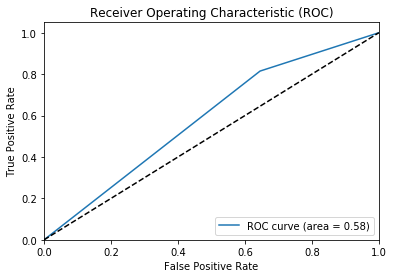

In [28]:
# 3단계
plot_roc(y_pred,Y_test)

In [29]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.5848


In [270]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.5054


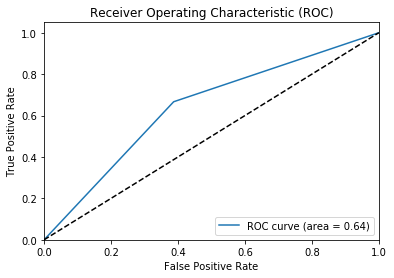

In [117]:
# 3단계
plot_roc(y_pred,Y_test)

In [119]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.6398


## Drop & Batch

In [148]:
y_pred # 1단계

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [47]:
y_pred # 1단계

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [206]:
y_pred # 2단계

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [76]:
y_pred # 2단계

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [271]:
y_pred # 3단계

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [99]:
y_pred # 3단계

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [29]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    20, 10))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

In [30]:
# 예측.
# y_hat = model.predict(x_test, batch_size = 1)
print(len(y_test))
print(len(y_pred))

58
58


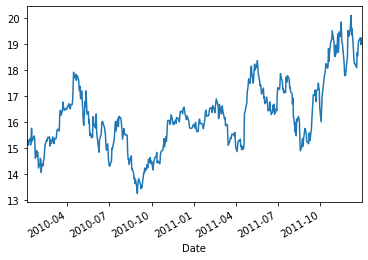

In [160]:
train_sample_df['Adj Close'].plot()

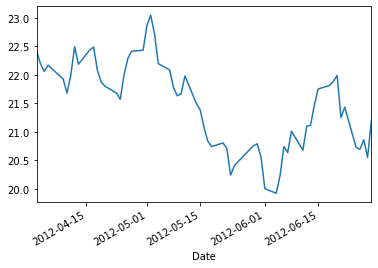

In [161]:
test_sample_df['Adj Close'].plot()

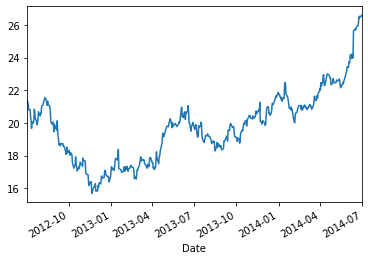

In [79]:
train_sample_df['Adj Close'].plot()

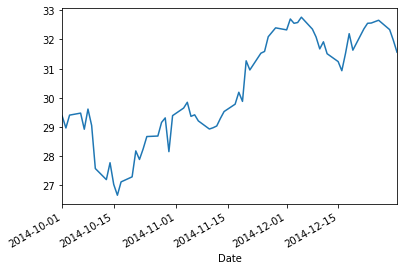

In [185]:
test_sample_df['Adj Close'].plot()

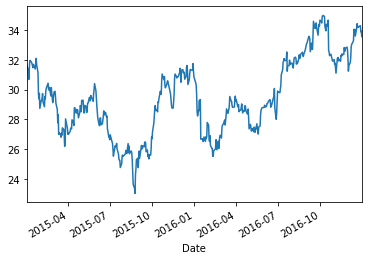

In [164]:
train_sample_df['Adj Close'].plot()

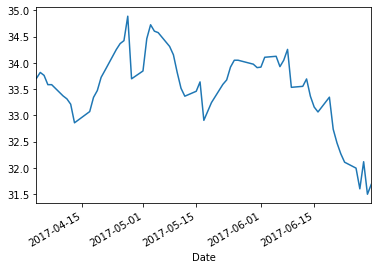

In [165]:
test_sample_df['Adj Close'].plot()

In [31]:
# 단계 
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

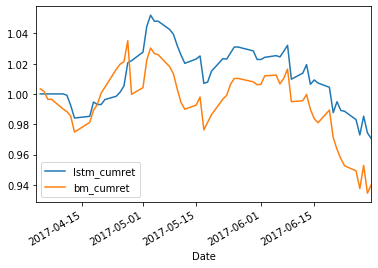

In [32]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

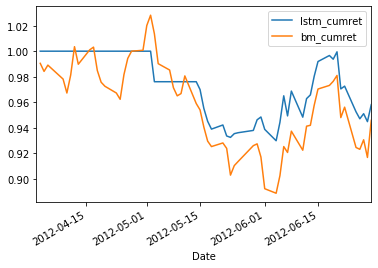

In [159]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

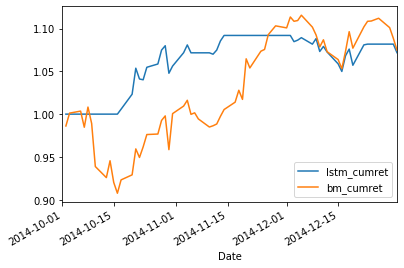

In [41]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

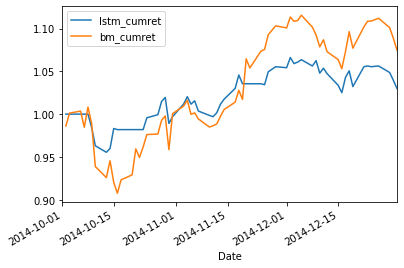

In [84]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

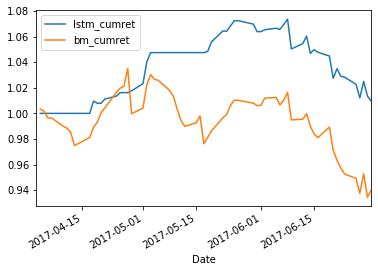

In [32]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

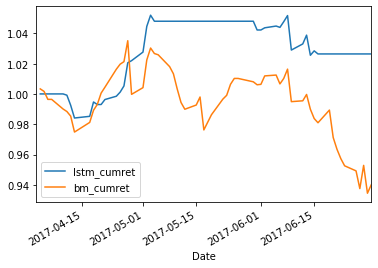

In [106]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

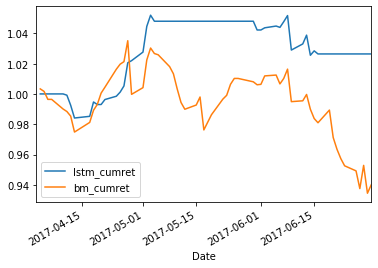

In [107]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

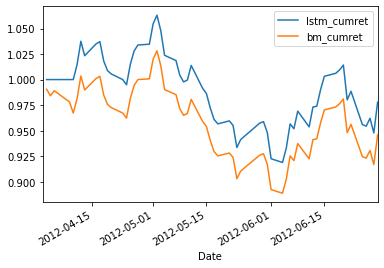

In [116]:
# 2단계 
lstm_book_df = test_sample_df[['Adj Close']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['ret'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

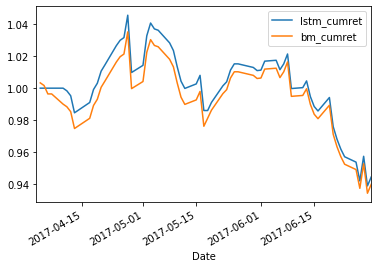

In [96]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['ret'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

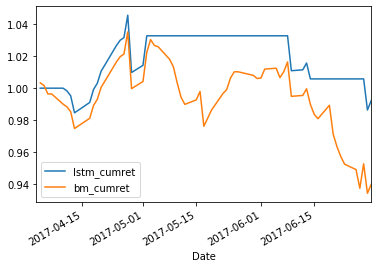

In [92]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['ret'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

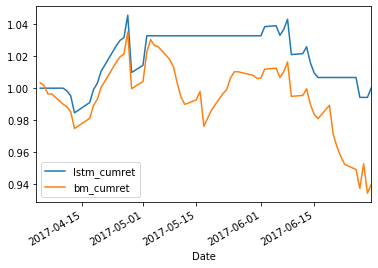

In [219]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['ret'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

# Backtesting

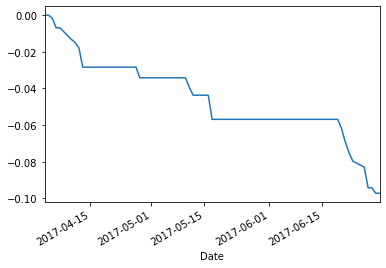

In [33]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

## BM

In [34]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -21.92 %
Sharpe :  -1.62
VOL :  14.82 %
MDD :  9.73 %


## LSTM

In [35]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -11.28 %
Sharpe :  -1.04
VOL :  11.11 %
MDD :  9.73 %
